In [22]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/src')

import numpy as np
from deformation import *
from scipy.optimize import minimize, fmin_l_bfgs_b, Bounds
import imageio

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.backends.backend_agg import FigureCanvasAgg

torchdeviceId = torch.device('cuda:0') 
torchdtype = torch.float64

### Read and prepare data

In [2]:
data = torch.load('../Data/amygdala.pt')
amyg_sour = data['Source']
amyg_tar = data['Target']

VS = torch.from_numpy(amyg_sour['x']).clone().to(dtype=torchdtype, device=torchdeviceId)
FS = torch.from_numpy(amyg_sour['G']).clone().to(dtype=torch.long, device=torchdeviceId)
VT = torch.from_numpy(amyg_tar['x']).clone().to(dtype=torchdtype, device=torchdeviceId)
FT = torch.from_numpy(amyg_tar['G']).clone().to(dtype=torch.long, device=torchdeviceId)

Source = mesh2var(VS,FS)
Target = mesh2var(VT,FT)

results = {'amyg_sour':amyg_sour, 'amyg_tar':amyg_tar}

### Set parameters

In [3]:
'''model parameters'''
options = {}
options['defo_kernel_size'] = 4.75
options['odemethod'] = 'rk4'
options['nb_euler_steps'] = 15
options['kernel_geom'] = 'gaussian'
options['kernel_grass'] = 'binet'
options['sig_geom'] = 3
options['sig_grass'] = 1.1
options['weight_varifold_dist'] = 10
#options['weight_meta'] = .00001

'''optimization parameters'''
opt_par = {'gtol': 1e-6, 'disp': True, 'step_size':1e-4, 
           'maxiter': 200, 'maxls': 50}

### LDDMM-Fisher-Rao model

In [4]:
'''model parameters'''
options = {}
options['defo_kernel_size'] = 4.75
options['odemethod'] = 'rk4'
options['nb_euler_steps'] = 15
options['kernel_geom'] = 'gaussian'
options['kernel_grass'] = 'binet'
options['sig_geom'] = 3
options['sig_grass'] = 1.1
options['weight_varifold_dist'] = 10
options['weight_meta'] = 0.1
options['model'] = 'metapf'


'''optimization parameters'''
opt_par = {'gtol': 1e-6, 'disp': True, 'step_size':1e-4, 'maxiter': 200, 'maxls': 50}

energy_scipy = enr_scipy(Source,Target,**options) #Energy function
p = np.zeros(list2vec(Source).shape[0])
a = np.zeros(Source[0].shape[0])
x0 = np.concatenate((p,a))

start = time.time()

#res = minimize(energy_scipy, x0, method='L-BFGS-B', jac=True, options=opt_par)
res = GD_adapted(energy_scipy,x0,**opt_par)
reg_time = round(time.time() - start, 2)

_,_, Enr_dic = energy_scipy(res.x)
results['metapf'] = {'res':res,'Enr_dic':Enr_dic,'options':options,'time':reg_time}

torch.save(results,'amygdala_FR_result.pt')

iter:1 | fun:2.03428e+05 | grad norm:4.64892e+05 | step size:1.71875e-06 | # step size search 6
iter:2 | fun:1.80834e+05 | grad norm:5.12501e+05 | step size:1.89063e-06 | # step size search 0
iter:3 | fun:8.31419e+04 | grad norm:1.81917e+05 | step size:1.03984e-06 | # step size search 1
iter:4 | fun:7.35468e+04 | grad norm:1.22297e+05 | step size:1.14383e-06 | # step size search 0
iter:5 | fun:6.96767e+04 | grad norm:1.08093e+05 | step size:1.25821e-06 | # step size search 0
iter:6 | fun:6.76843e+04 | grad norm:1.16642e+05 | step size:1.38403e-06 | # step size search 0
iter:7 | fun:6.30773e+04 | grad norm:4.67954e+04 | step size:7.61218e-07 | # step size search 1
iter:8 | fun:6.16915e+04 | grad norm:4.08158e+04 | step size:8.37339e-07 | # step size search 0
iter:9 | fun:6.03692e+04 | grad norm:3.88352e+04 | step size:9.21073e-07 | # step size search 0
iter:10 | fun:5.90207e+04 | grad norm:3.74496e+04 | step size:1.01318e-06 | # step size search 0
iter:11 | fun:5.76331e+04 | grad norm:3

iter:86 | fun:1.62514e+04 | grad norm:1.22645e+04 | step size:1.38430e-06 | # step size search 0
iter:87 | fun:1.60546e+04 | grad norm:1.22617e+04 | step size:1.52273e-06 | # step size search 0
iter:88 | fun:1.58452e+04 | grad norm:1.25335e+04 | step size:1.67501e-06 | # step size search 0
iter:89 | fun:1.56280e+04 | grad norm:1.37359e+04 | step size:1.84251e-06 | # step size search 0
iter:90 | fun:1.54305e+04 | grad norm:1.82540e+04 | step size:2.02676e-06 | # step size search 0
iter:91 | fun:1.54191e+04 | grad norm:3.35120e+04 | step size:2.22943e-06 | # step size search 0
iter:92 | fun:1.51502e+04 | grad norm:2.65902e+04 | step size:1.22619e-06 | # step size search 1
iter:93 | fun:1.49763e+04 | grad norm:2.52038e+04 | step size:1.34881e-06 | # step size search 0
iter:94 | fun:1.48595e+04 | grad norm:2.78423e+04 | step size:1.48369e-06 | # step size search 0
iter:95 | fun:1.48490e+04 | grad norm:3.60445e+04 | step size:1.63206e-06 | # step size search 0
iter:96 | fun:1.44120e+04 | gr

iter:170 | fun:7.76090e+03 | grad norm:6.69422e+03 | step size:2.02715e-06 | # step size search 0
iter:171 | fun:7.69890e+03 | grad norm:8.63934e+03 | step size:2.22987e-06 | # step size search 0
iter:172 | fun:7.68238e+03 | grad norm:1.61132e+04 | step size:2.45286e-06 | # step size search 0
iter:173 | fun:7.62115e+03 | grad norm:1.41979e+04 | step size:1.34907e-06 | # step size search 1
iter:174 | fun:7.58108e+03 | grad norm:1.47601e+04 | step size:1.48398e-06 | # step size search 0
iter:175 | fun:7.56579e+03 | grad norm:1.79641e+04 | step size:1.63238e-06 | # step size search 0
iter:176 | fun:7.44905e+03 | grad norm:7.04714e+03 | step size:8.97806e-07 | # step size search 1
iter:177 | fun:7.41473e+03 | grad norm:5.90752e+03 | step size:9.87587e-07 | # step size search 0
iter:178 | fun:7.38197e+03 | grad norm:5.74258e+03 | step size:1.08635e-06 | # step size search 0
iter:179 | fun:7.34671e+03 | grad norm:5.68898e+03 | step size:1.19498e-06 | # step size search 0
iter:180 | fun:7.308

In [6]:
N,d = Source[0].shape
flowmp = Flow_set(**options)
p_op = res.x[:len(Source)*N*d]
p_op_alpha = res.x[len(Source)*N*d:]

P_op = vec2list(torch.from_numpy(p_op).clone().detach().to(dtype=torchdtype,device=torchdeviceId),N,d)
P_op_alpha = torch.from_numpy(p_op_alpha).clone().detach().to(dtype=torchdtype,device=torchdeviceId)
obj_evol = flowmp(VS,P_op,Source,P_op_alpha)

In [16]:
%matplotlib notebook

<IPython.core.display.Javascript object>


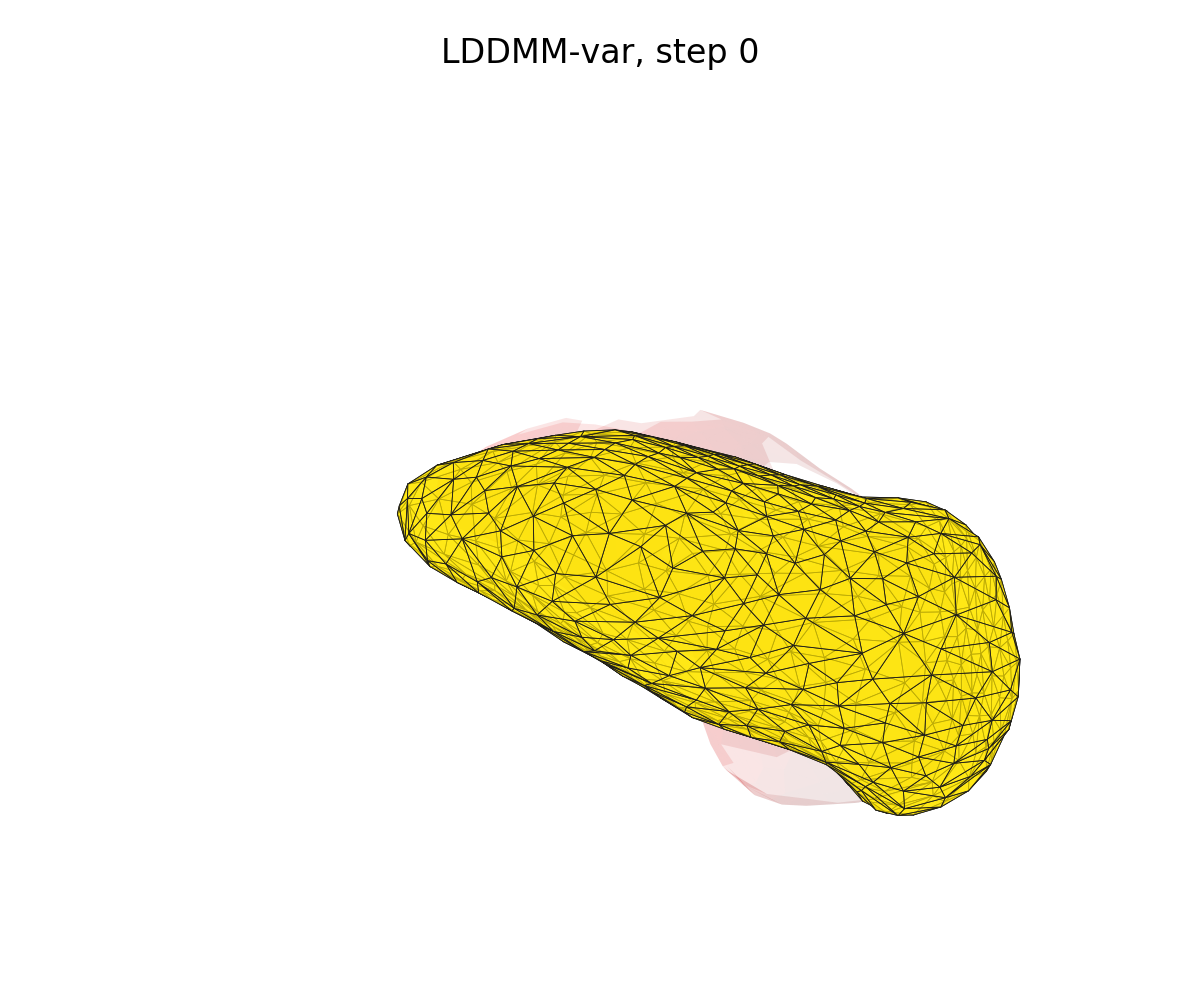

<IPython.core.display.Javascript object>


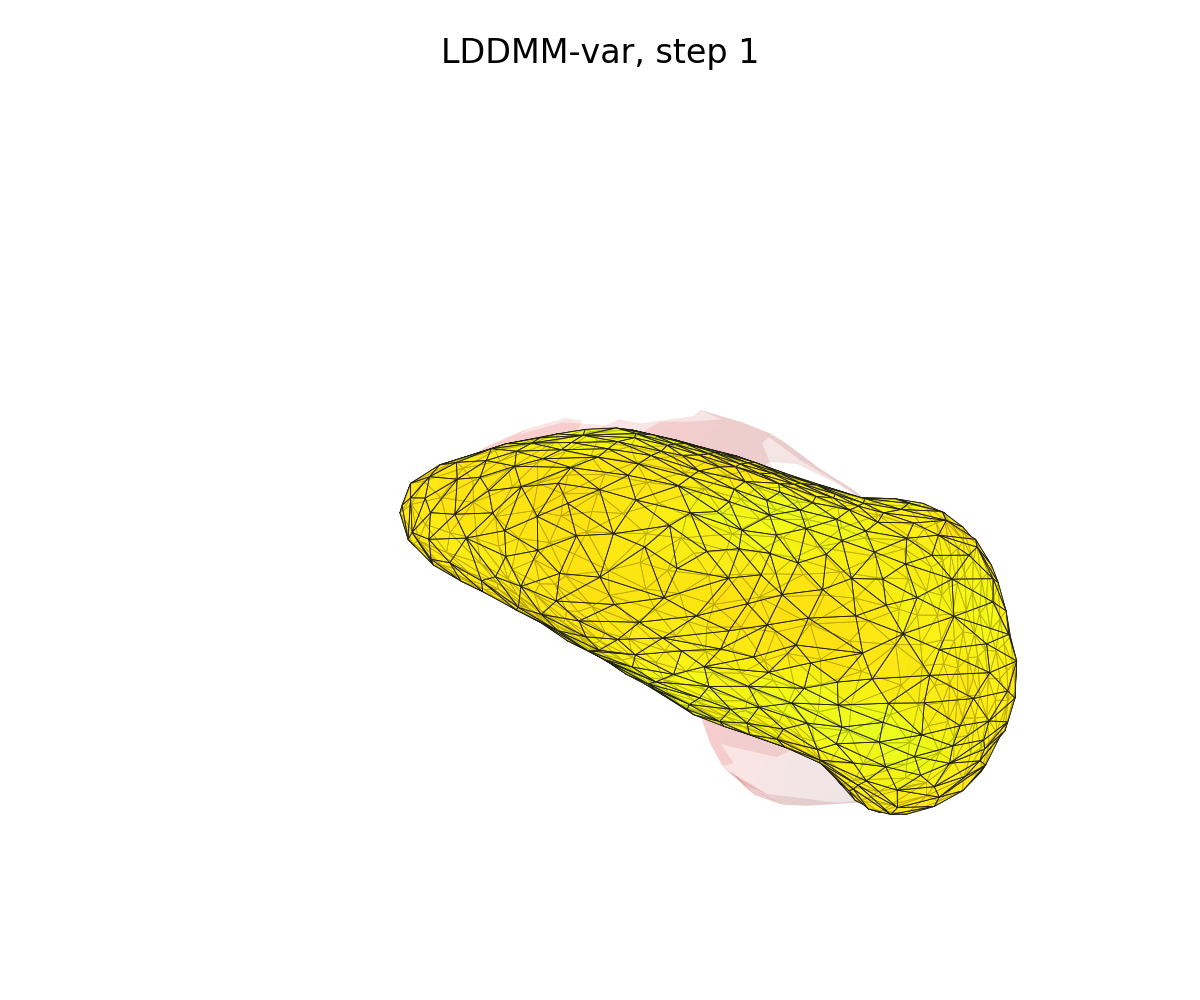

<IPython.core.display.Javascript object>


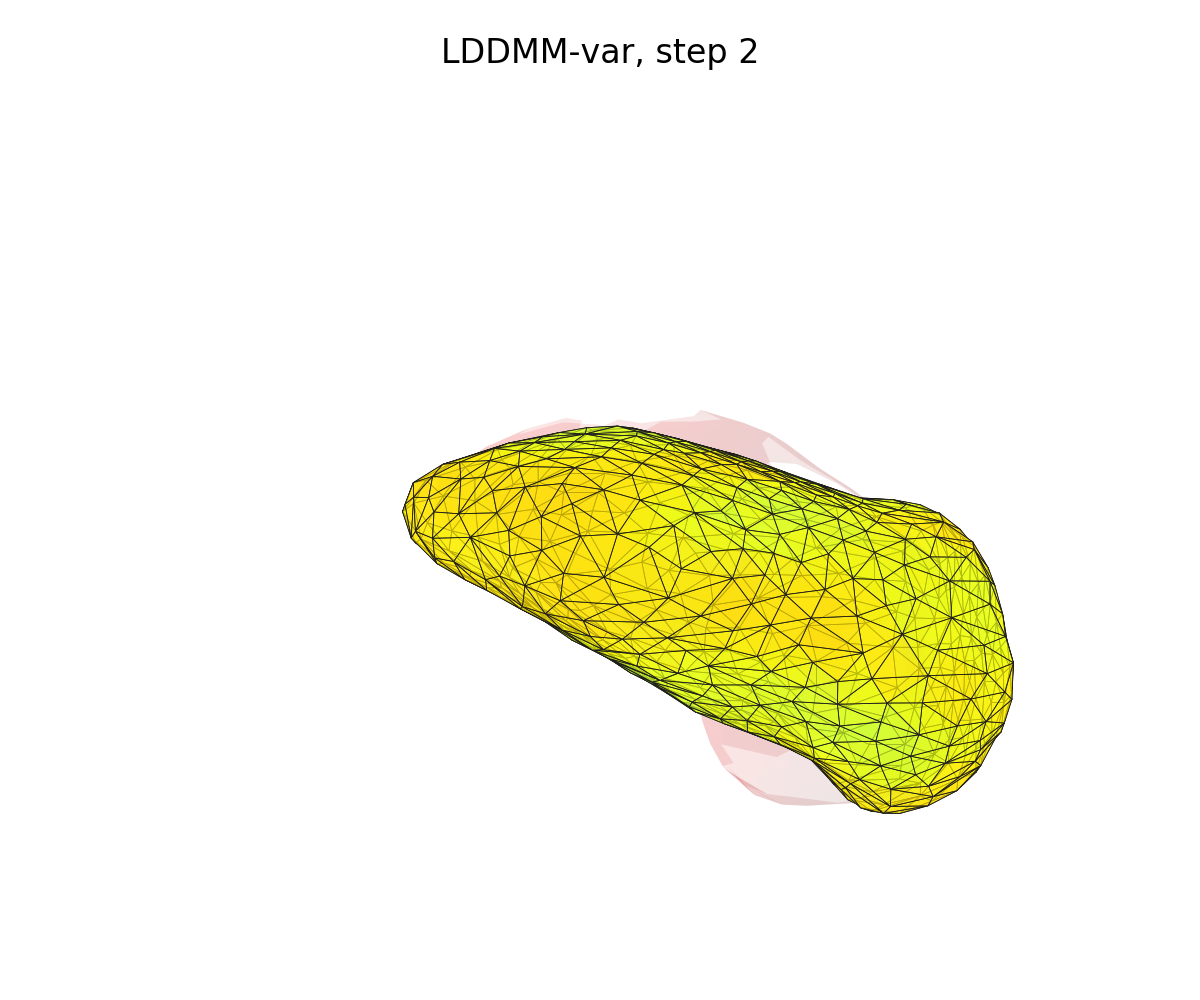

<IPython.core.display.Javascript object>


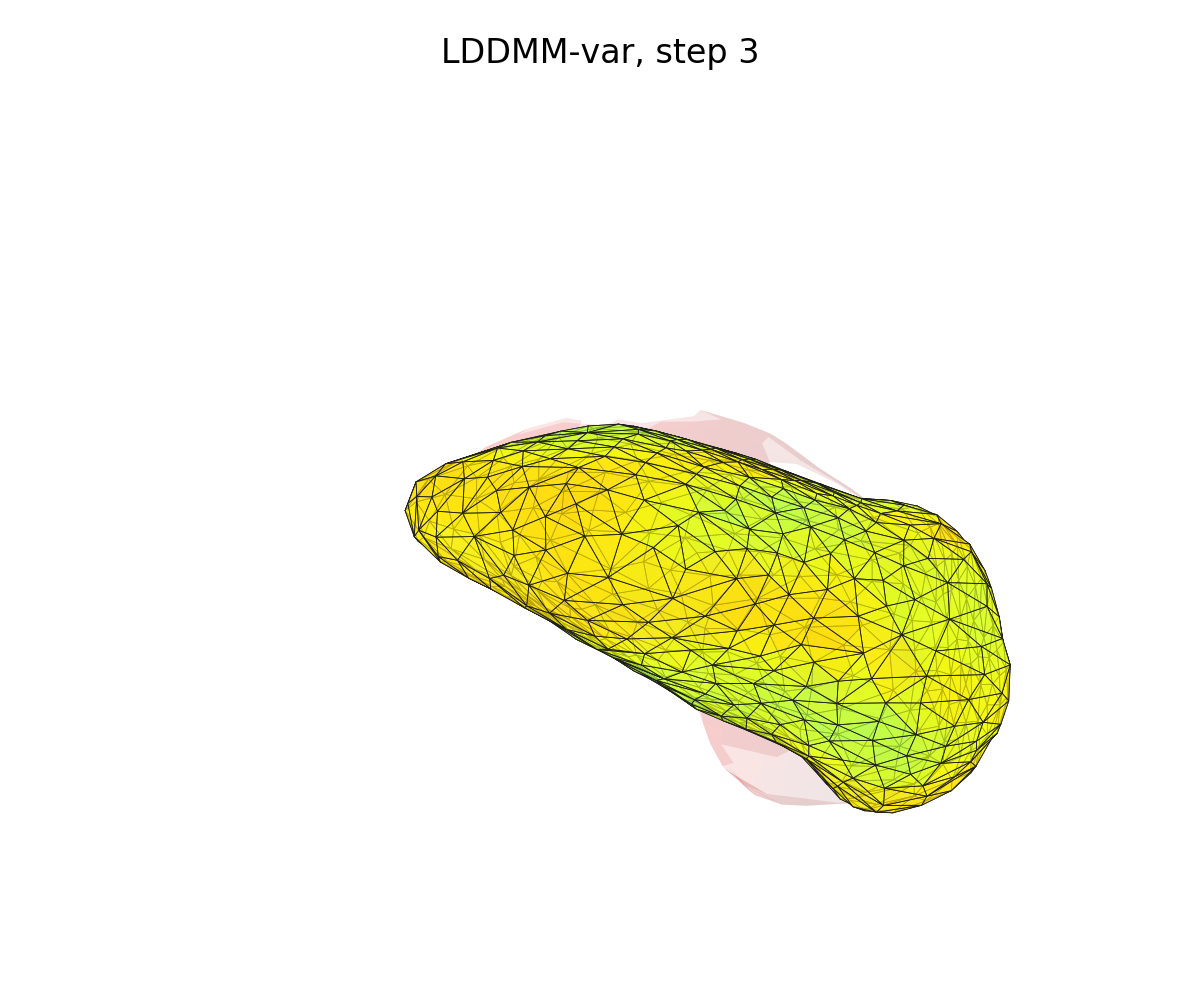

<IPython.core.display.Javascript object>


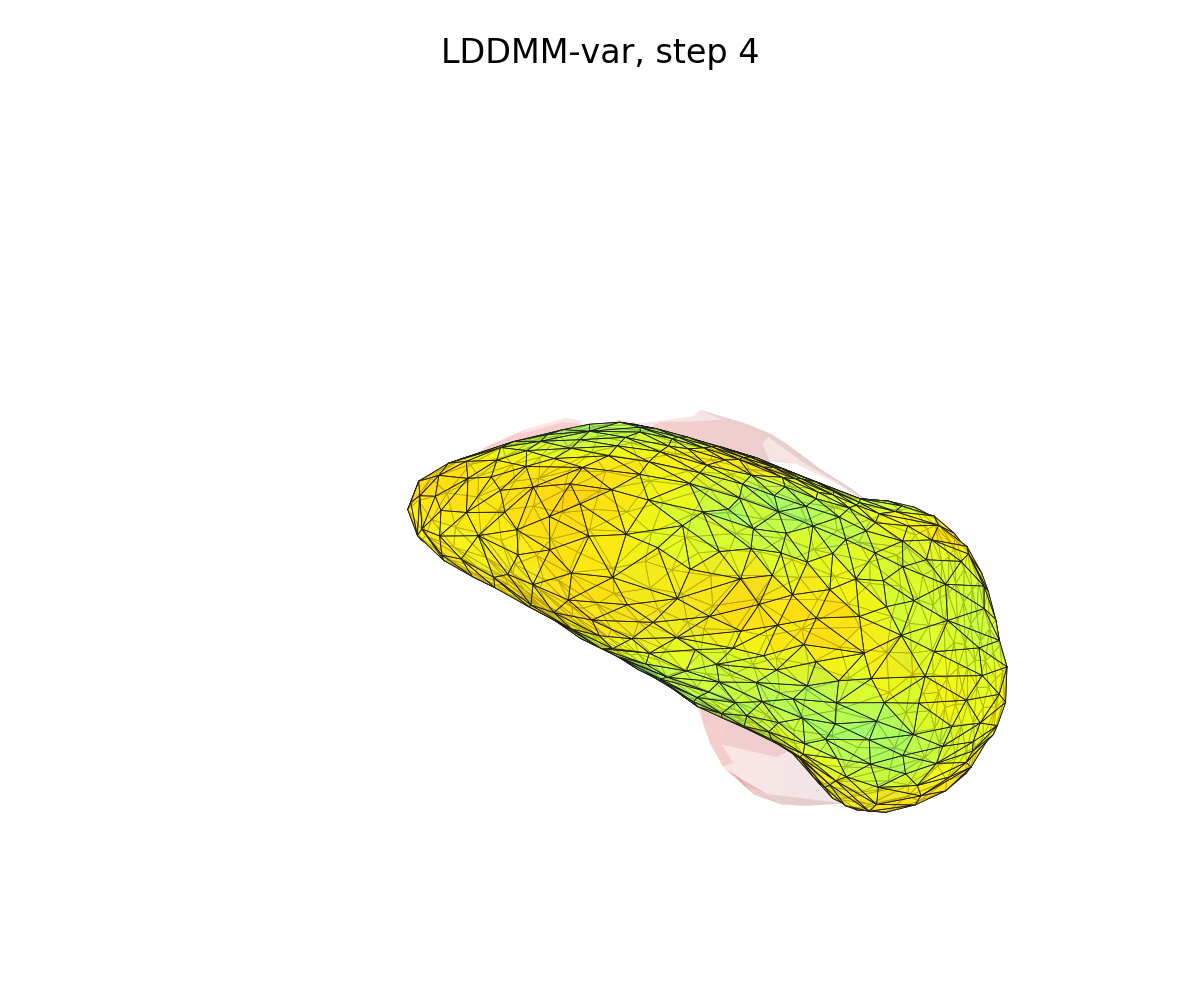

<IPython.core.display.Javascript object>


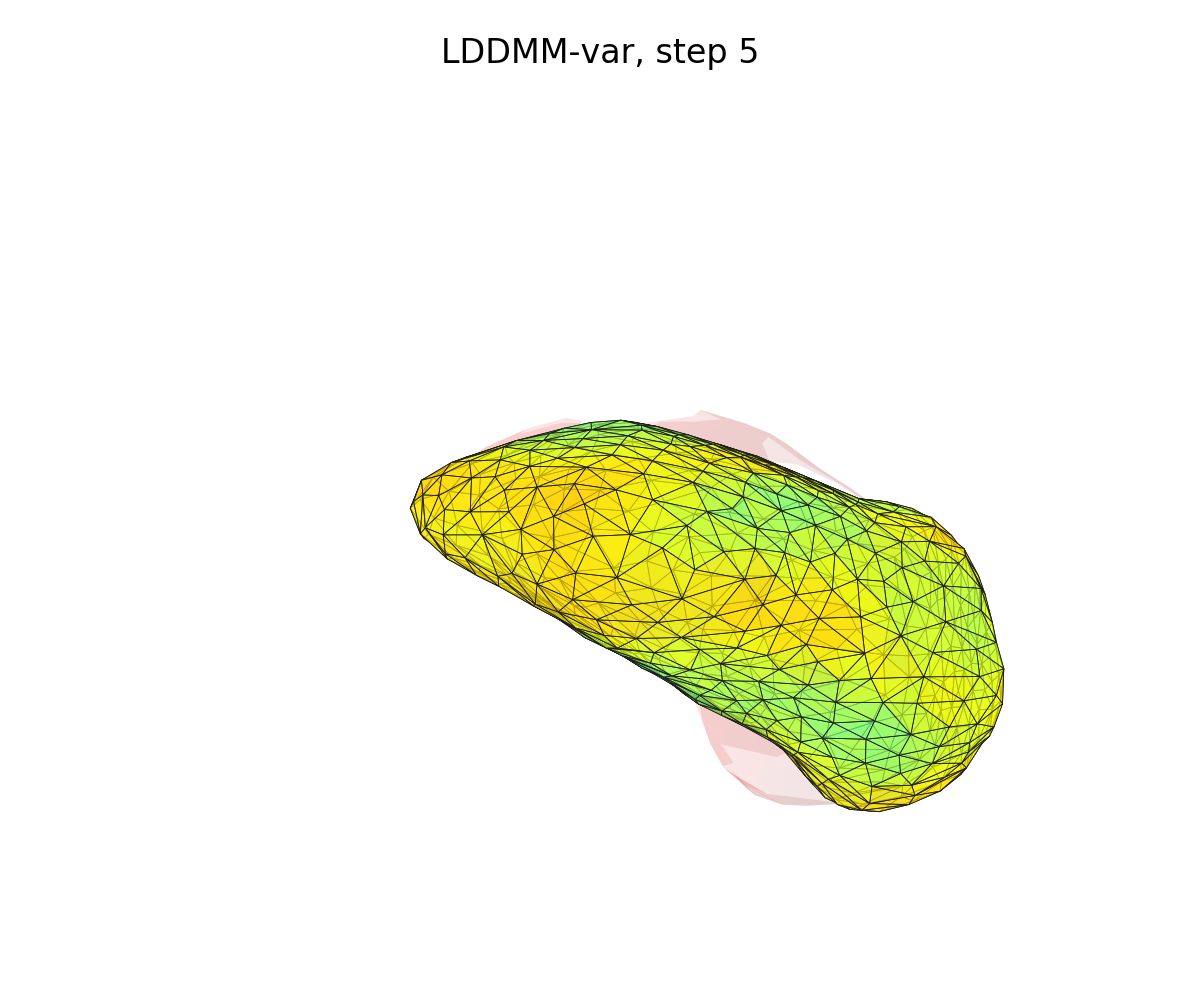

<IPython.core.display.Javascript object>


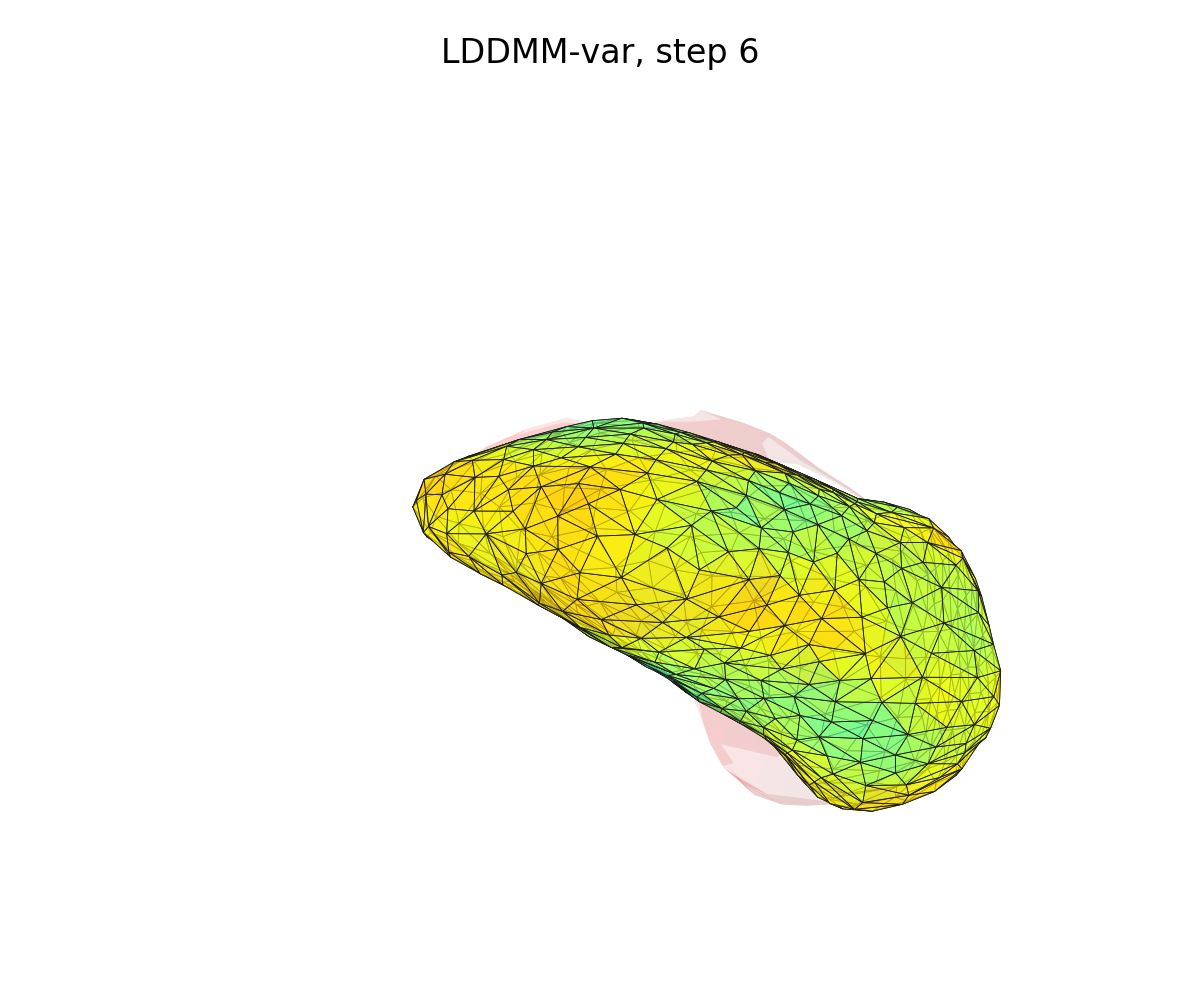

<IPython.core.display.Javascript object>


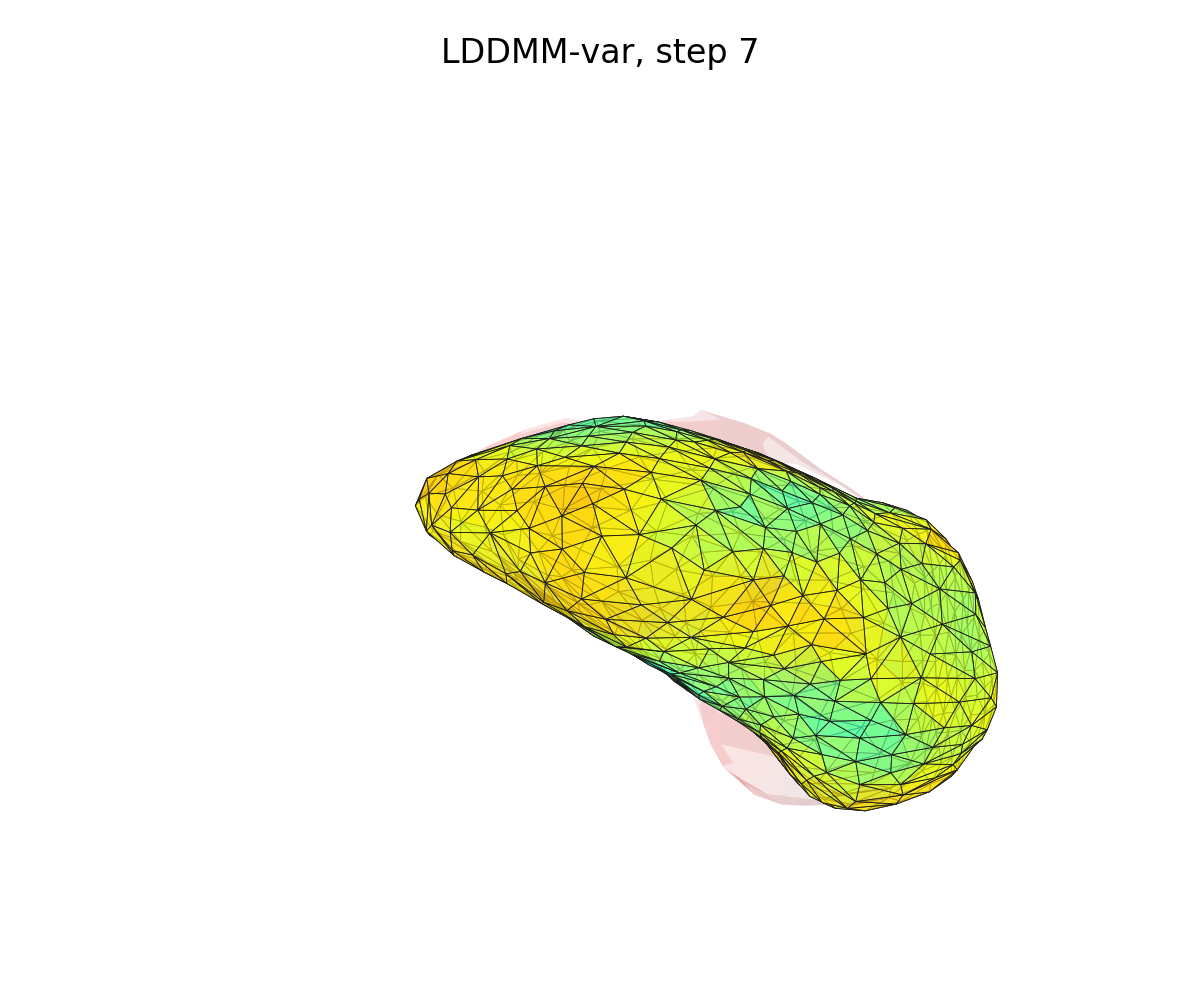

<IPython.core.display.Javascript object>


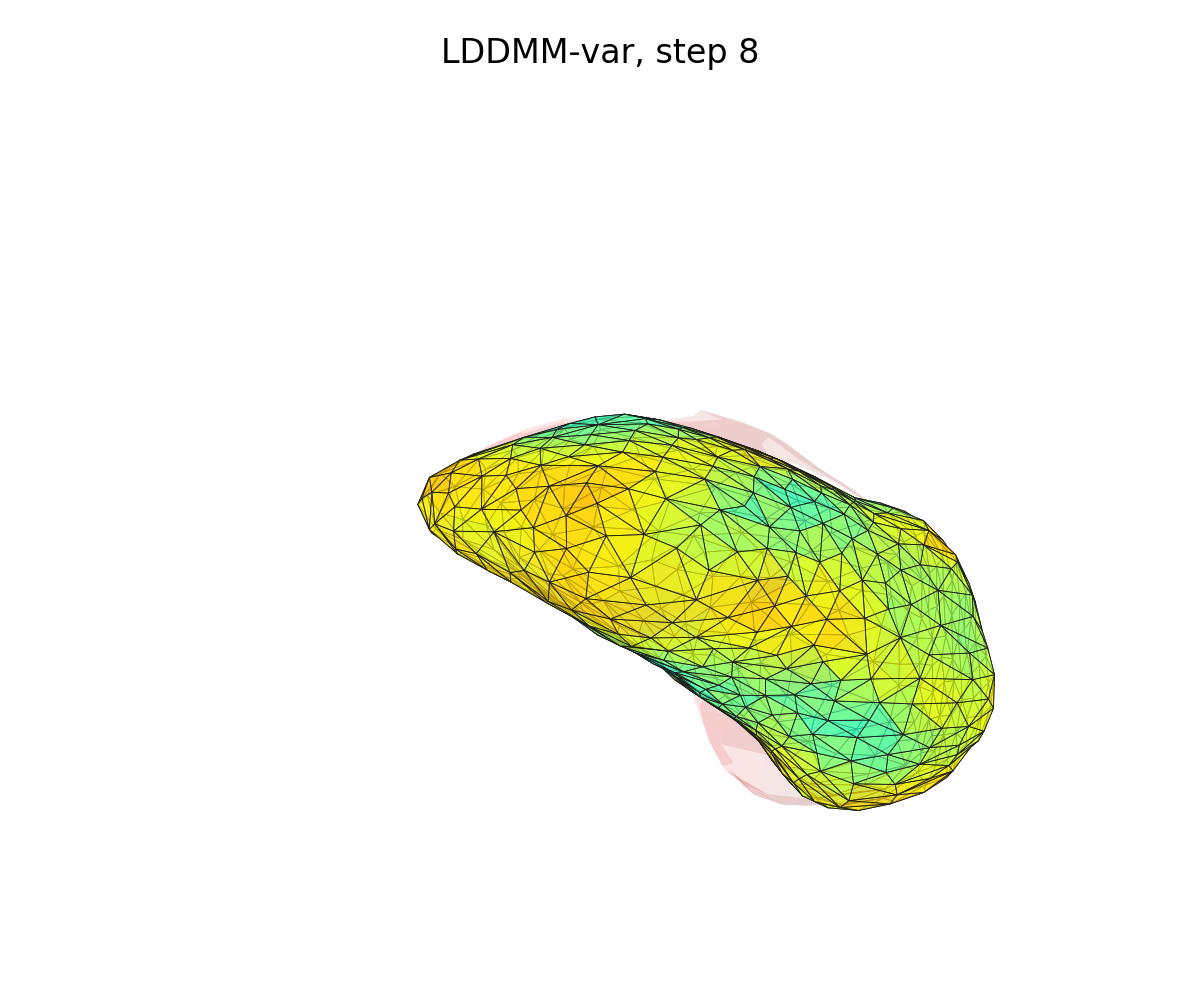

<IPython.core.display.Javascript object>


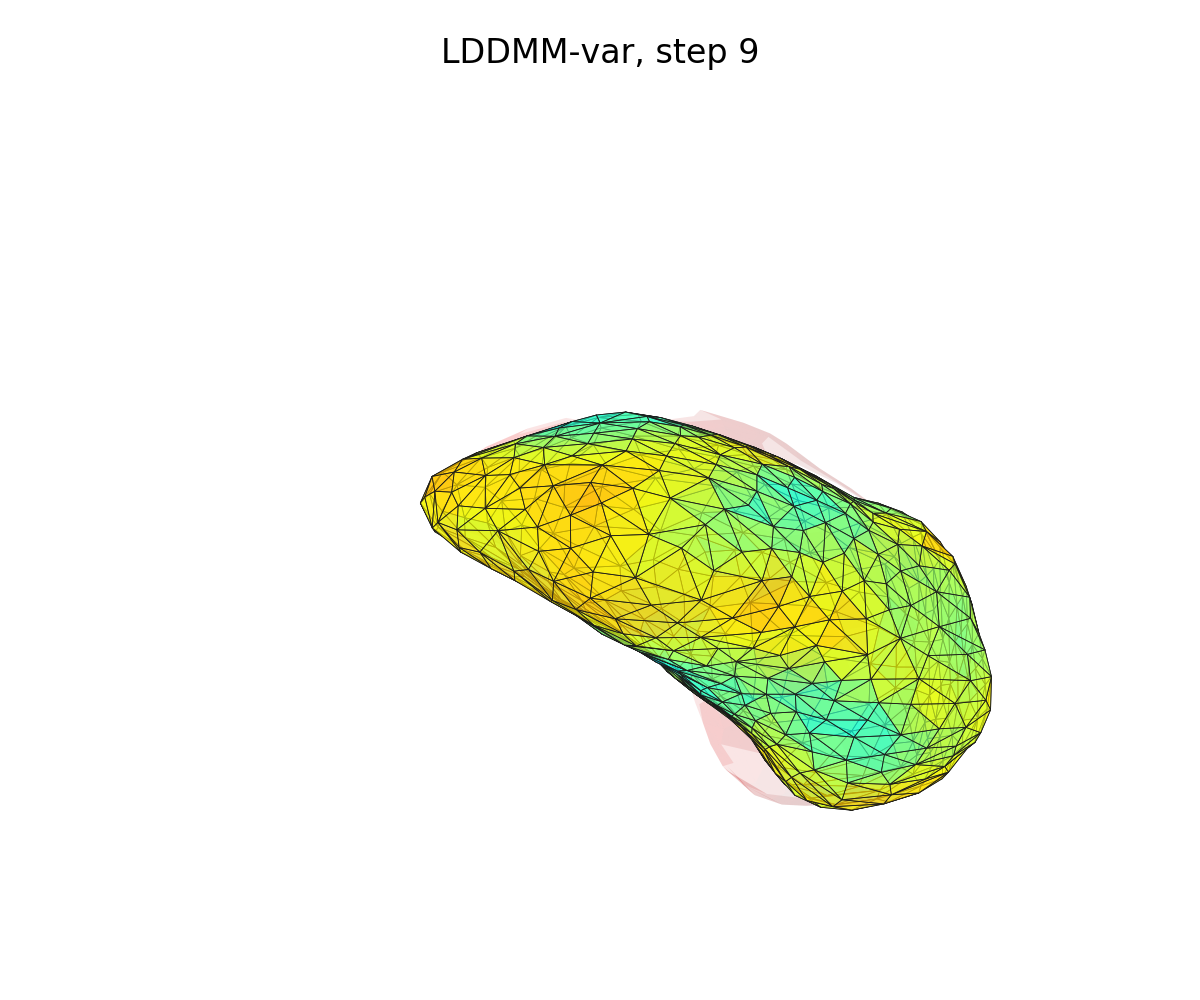

<IPython.core.display.Javascript object>


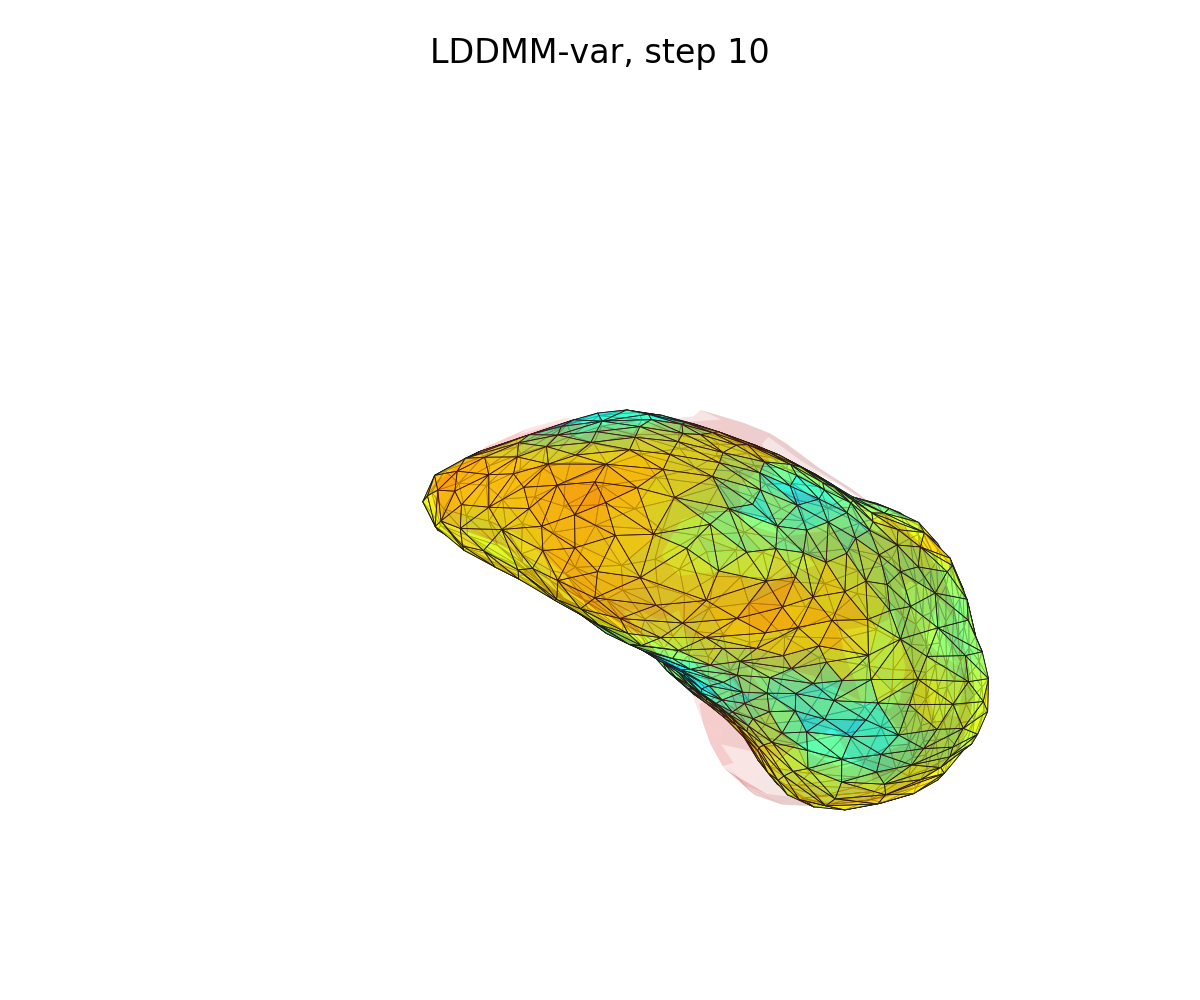

<IPython.core.display.Javascript object>


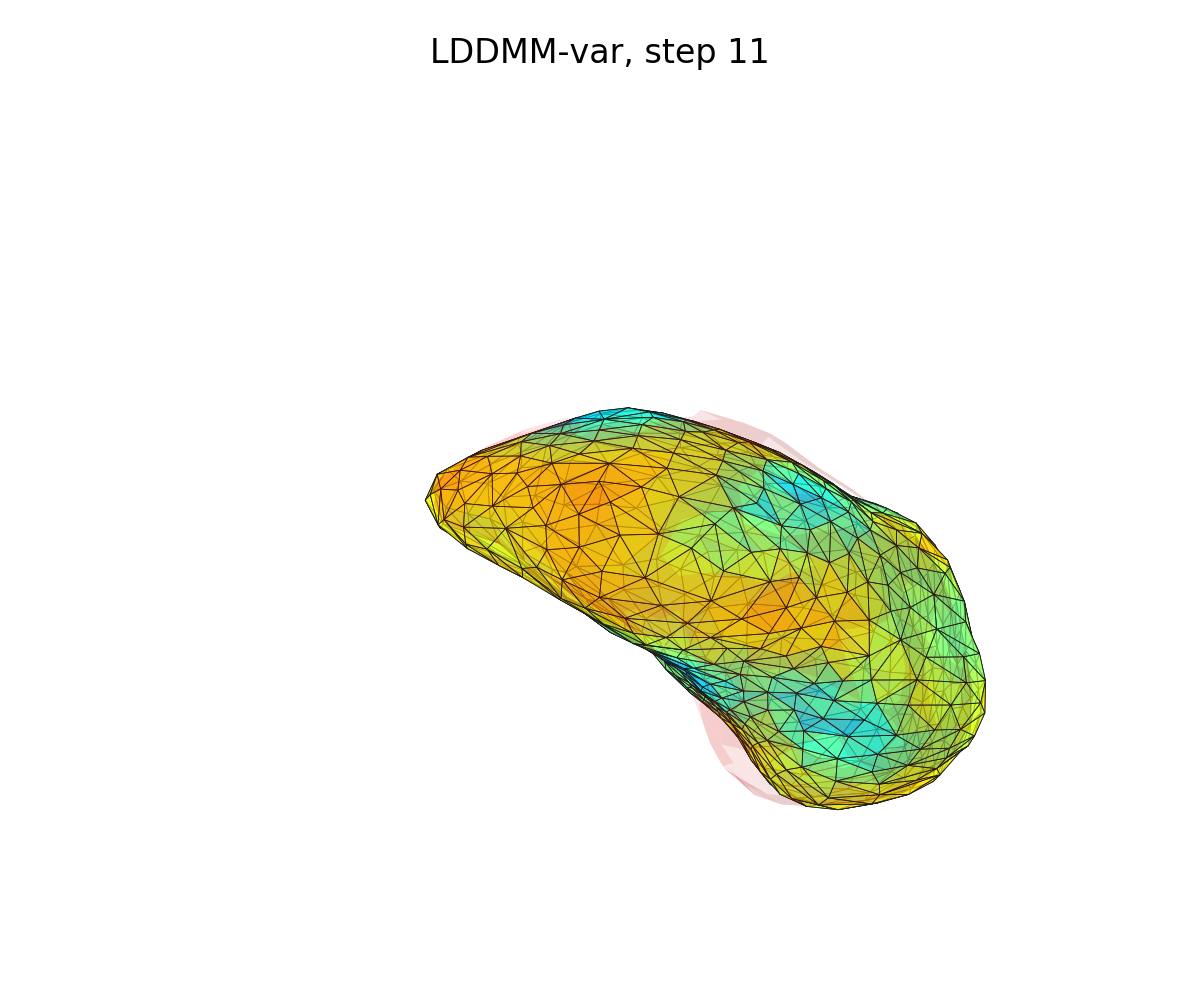

<IPython.core.display.Javascript object>


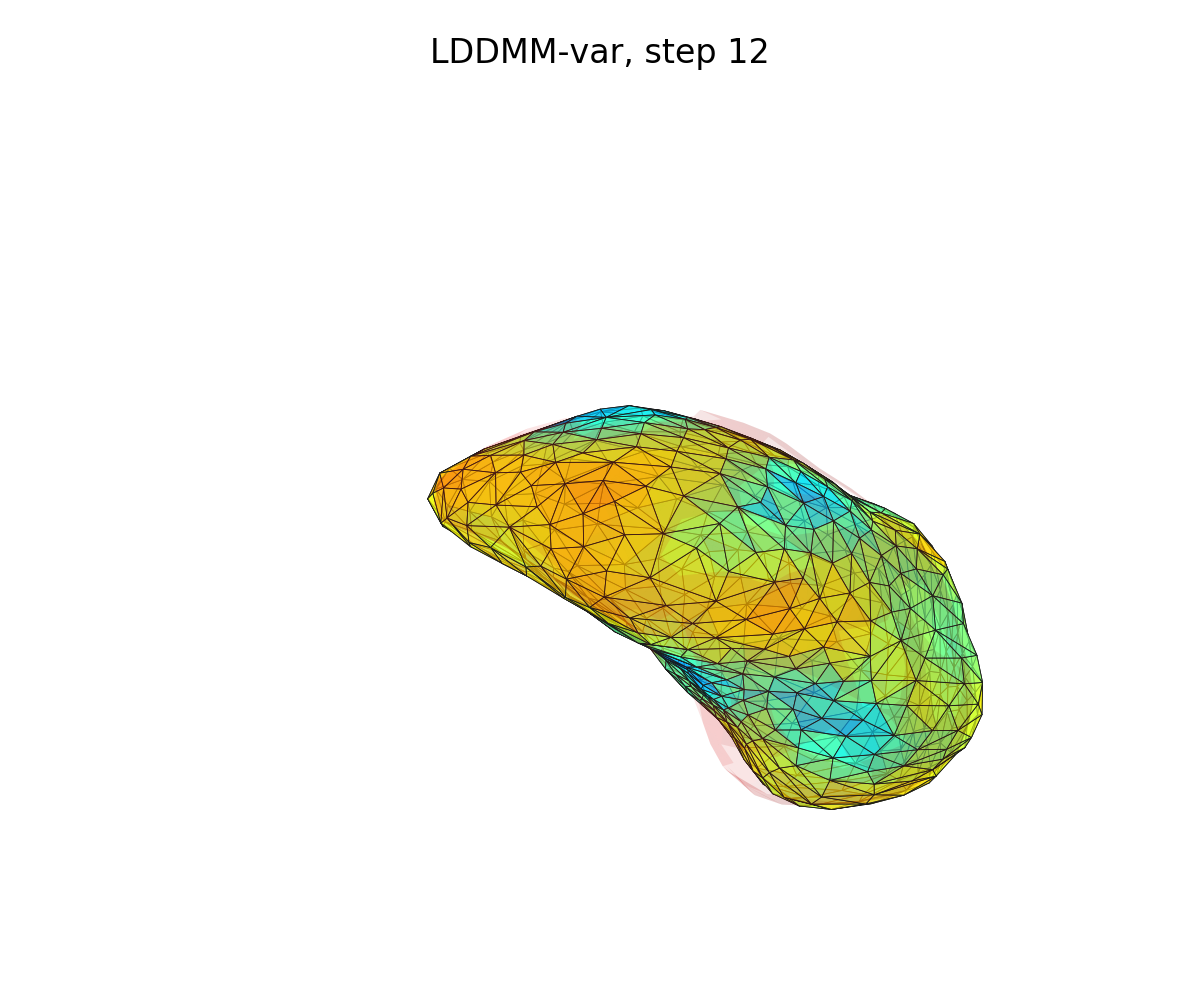

<IPython.core.display.Javascript object>


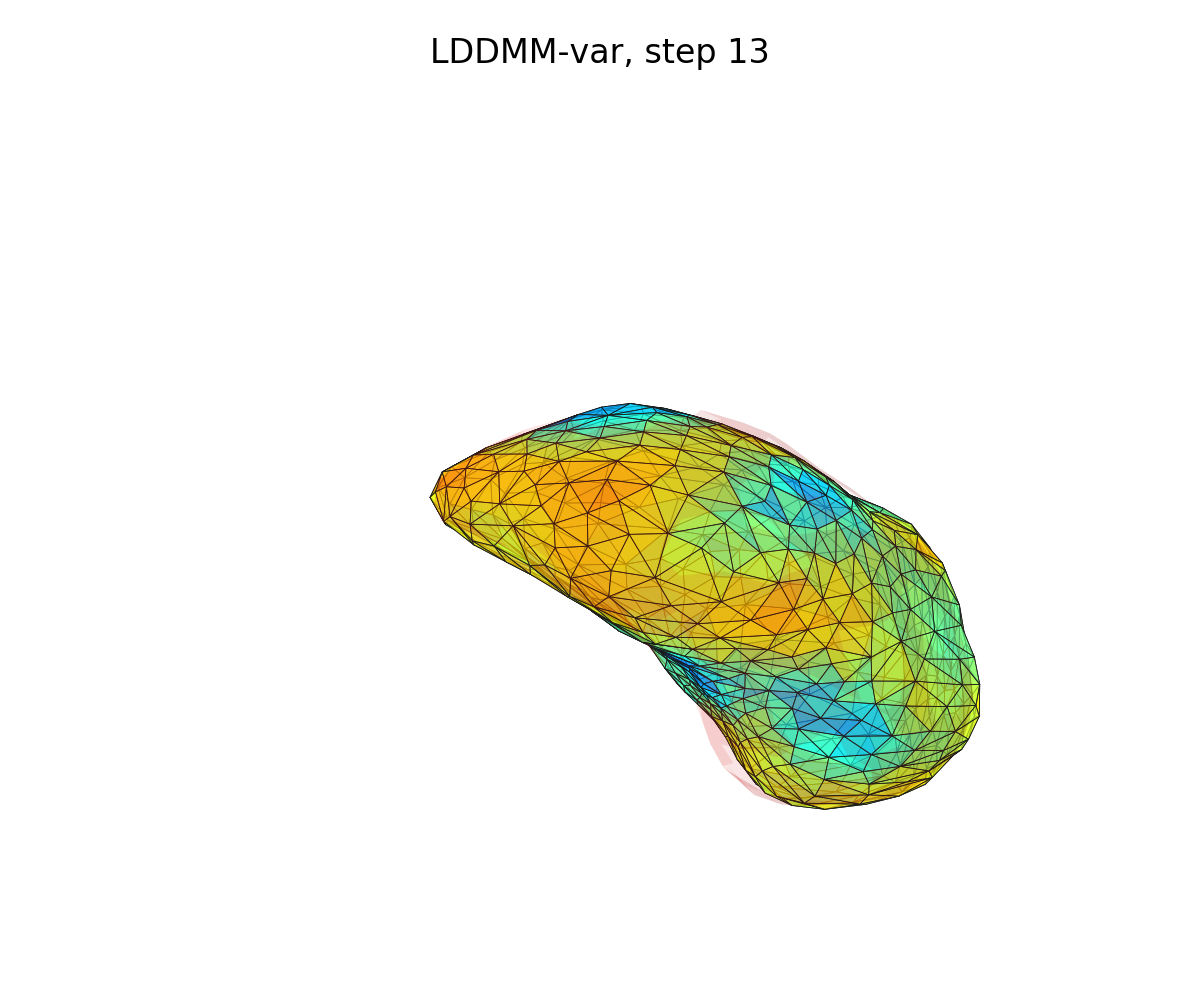

<IPython.core.display.Javascript object>


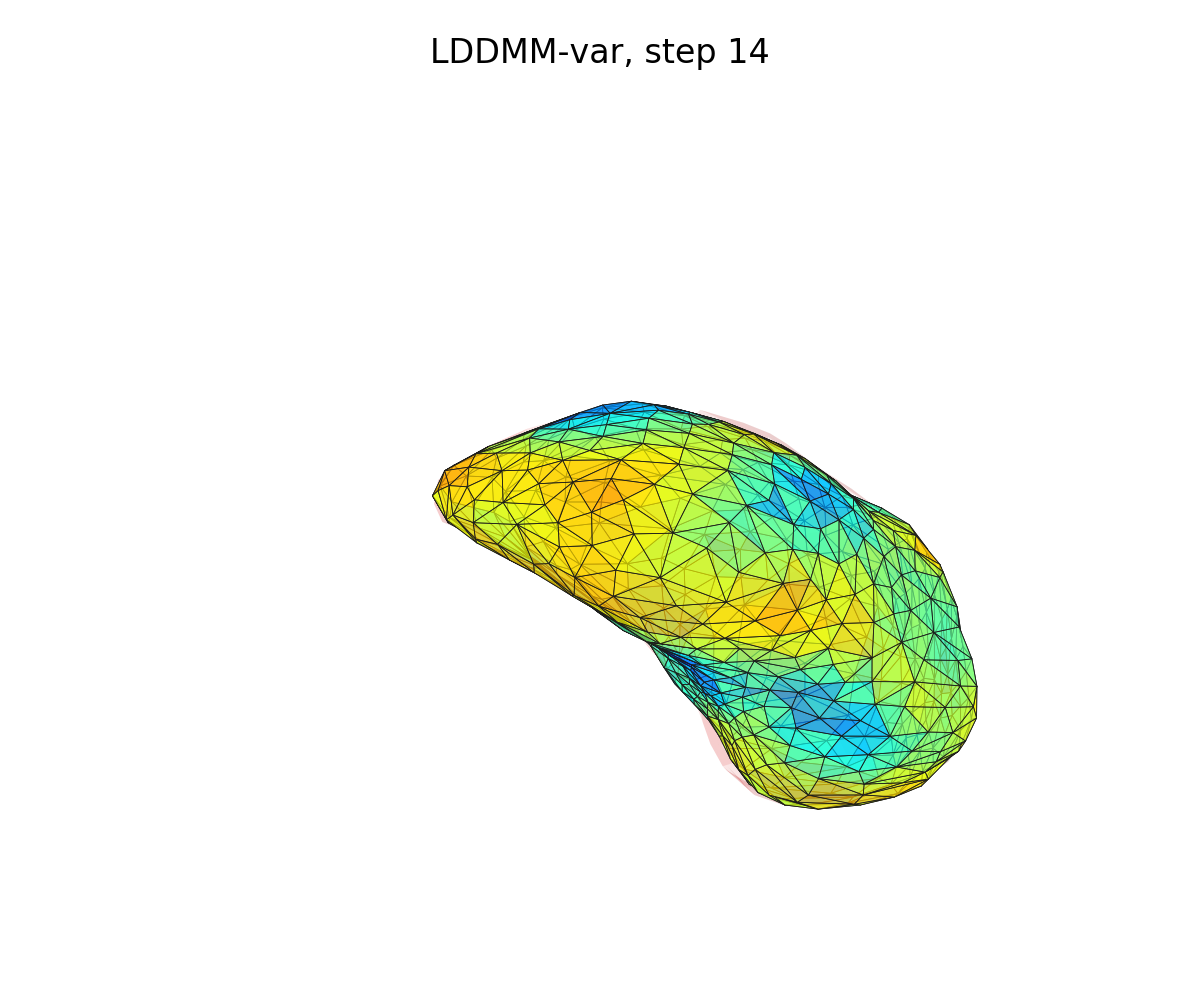

<IPython.core.display.Javascript object>


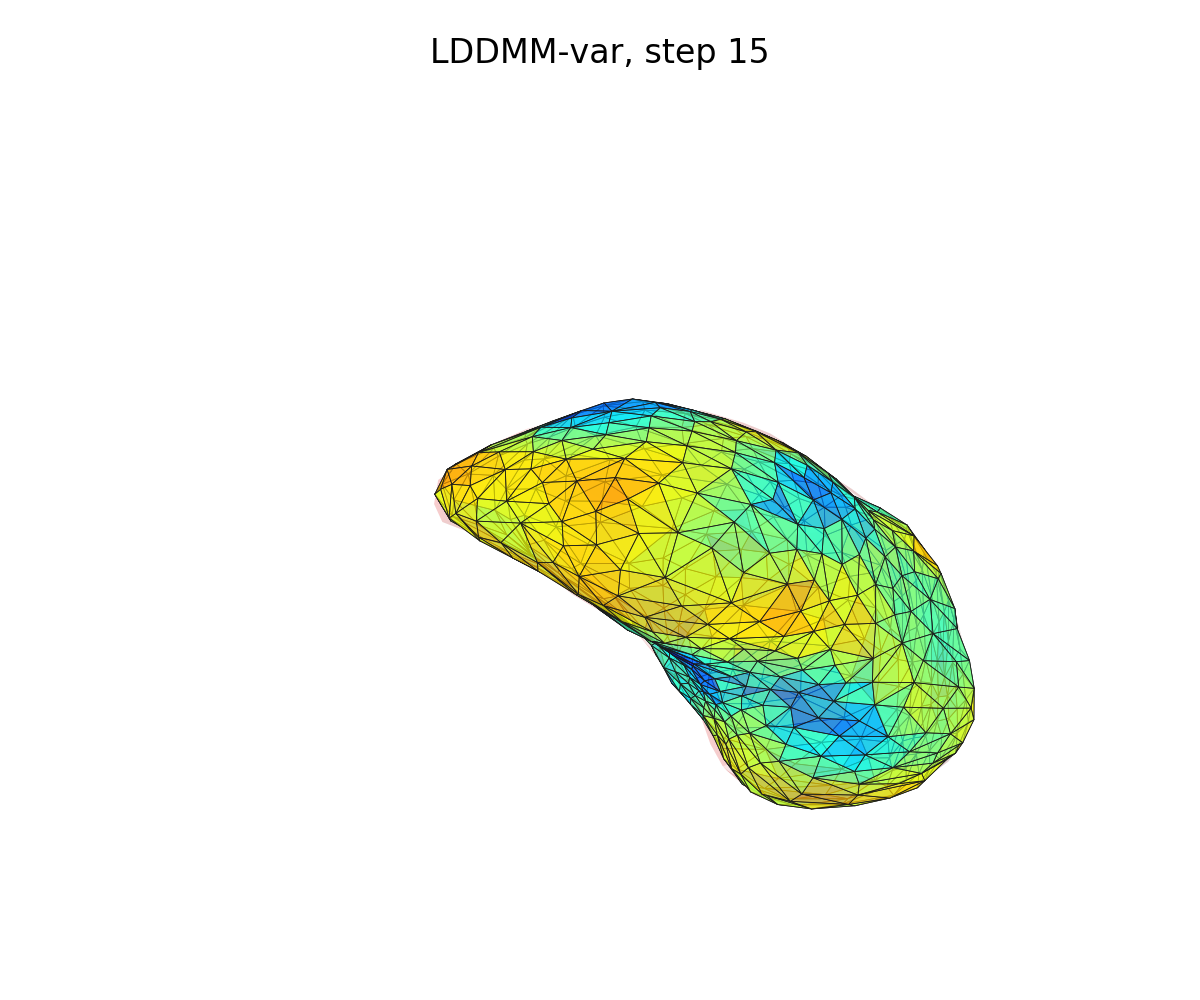

In [123]:
m = cm.ScalarMappable(cmap=cm.jet)
m.set_clim(0,1.5)

plt.ion()
images = []
save_folder = './LDDMM_var_result/'
os.makedirs(save_folder, exist_ok=True)

for t in range(options['nb_euler_steps']+1):
    fig = plt.figure(figsize=(6,5),dpi=100)
    # Link canvas to fig
    canvas = FigureCanvasAgg(fig)
    
    ax = Axes3D(fig)
    ax.cla()
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    alpha_t = obj_evol[1][t][-1].cpu().numpy()**2
    pt = obj_evol[0][t].detach().cpu().numpy()

    surf = ax.plot_trisurf(pt[:, 0],
                               pt[:, 1],
                               pt[:, 2],
                               triangles=amyg_sour['G'],
                               linewidth=.3,cmap=cm.jet, 
                               edgecolor = (.1, .1, .1, 1),
                               alpha=0.7)
    surf.set_array(alpha_t)

    surf.set_clim(0,1.5)

    ax.plot_trisurf(amyg_tar['x'][:, 0],
                    amyg_tar['x'][:, 1],
                    amyg_tar['x'][:, 2],
                    triangles=amyg_tar['G'],
                    color='r',  linewidth=.5, edgecolor = None, 
                    alpha=0.1)

    #plt.colorbar(m,ax=ax, shrink=0.7)
    ax.set_xlim(85,110)
    ax.set_ylim(123,142)
    ax.set_zlim(98,118)
    ax.view_init( azim=-15, elev=17)
    ax.set_title('LDDMM-var, step ' + str(t))
    plt.axis('off')
    
    fig.canvas.draw()
    # save plot in a numpy array through buffer
    s, (width, height) = fig.canvas.print_to_buffer()
    images.append(np.frombuffer(s, np.uint8).reshape((height, width, 4)))


imageio.mimsave(save_folder+'amyg_LDDMM_var.gif', images, duration=.5)